1. In the first part you'll be processing the data in the geonames table.
  - Find the tuple with the largest population  
  - Now calculate the distance from all locations to the tuple above using the <-> function  
  - Now calculate the distance from all locations to the tuple above using the haversine distance. The haversine distance has been implemented in PL/PGSQL here: https://gist.github.com/carlzulauf/1724506  
  - Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot
  - You can use IPython-SQL or Pandas to create the plot

2. In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The gathering
  - Find all the cards that is made by Rob Alexander
  - Find all the cards that have the subtype "Human"
  - Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.

##### Hand-in: a 2-d plot of the latitude and longitudes of the 1000 largest populations from the geonames table and a histogram that counts the number of cards for each colour

In [4]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [5]:
%sql postgresql://appdev@data:5432/appdev

'Connected: appdev@appdev'

In [6]:
import numpy as np
import matplotlib.pyplot as plt

In [7]:
%%sql
SELECT * FROM geonames
ORDER BY population DESC
LIMIT 1;

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


In [8]:
%%sql
SELECT geonameid, name, point(longitude,latitude) <-> point(36.0,34.0) AS distance
FROM geonames
LIMIT 5;

5 rows affected.


geonameid,name,distance
3038871,Obac de la Vall,35.5187260391022
3038956,Canal del Teixó,35.5403912827645
3038989,Solana del Soriguer,35.4976906065648
3039152,Bosc de Sant Romà,35.5211340049413
3039170,Sant Esteve,35.5230848613757


In [9]:
%%sql
CREATE OR REPLACE FUNCTION public.geodistance(alat double precision, alng double precision, blat double precision, blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

In [10]:
%%sql
SELECT geonameid, name, geodistance(longitude,latitude,36.0,34.0) AS distance
FROM geonames
LIMIT 5;

5 rows affected.


geonameid,name,distance
3038871,Obac de la Vall,2447.02064247823
3038956,Canal del Teixó,2448.31370315787
3038989,Solana del Soriguer,2445.30508219456
3039152,Bosc de Sant Romà,2447.21932099428
3039170,Sant Esteve,2447.38555627568


1000 rows affected.


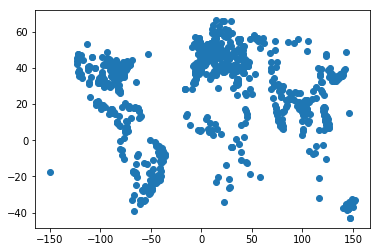

In [26]:
result = %sql SELECT longitude,latitude FROM geonames ORDER BY population DESC LIMIT 1000;
data = np.array(result)
x, y = data.T

plt.scatter(x,y)
plt.show()

In [12]:
%%sql
SELECT * FROM cards
LIMIT 1;

1 rows affected.


set,data
10E,"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"


In [13]:
%%sql
SELECT *
FROM cards
WHERE data @> '{"artist":"Rob Alexander"}'
LIMIT 5;

5 rows affected.


set,data
10E,"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"
10E,"{'id': '9cea331c080c3bbc7987c6560f65e39e9d1ed34f', 'cmc': 5, 'name': 'Kavu Climber', 'text': 'When Kavu Climber enters the battlefield, draw a card.', 'type': 'Creature — Kavu', 'power': '3', 'types': ['Creature'], 'artist': 'Rob Alexander', 'colors': ['Green'], 'flavor': '""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.""\n—Taseen, elvish bard', 'layout': 'normal', 'number': '273', 'rarity': 'Common', 'manaCost': '{3}{G}{G}', 'subtypes': ['Kavu'], 'imageName': 'kavu climber', 'mciNumber': '273', 'toughness': '3', 'multiverseid': 129511, 'colorIdentity': ['G']}"
10E,"{'id': '28cc7c79cca8939fd9661f7abfc6ca453715b75e', 'cmc': 0, 'name': 'Llanowar Wastes', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '355', 'rarity': 'Rare', 'imageName': 'llanowar wastes', 'mciNumber': '355', 'multiverseid': 129627, 'colorIdentity': ['B', 'G']}"
10E,"{'id': '7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20', 'cmc': 0, 'name': 'Shivan Reef', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '357', 'rarity': 'Rare', 'imageName': 'shivan reef', 'mciNumber': '357', 'multiverseid': 129731, 'colorIdentity': ['U', 'R']}"
10E,"{'id': '8d1035f151615c949d0645b70fe01d8ab4a3f796', 'cmc': 0, 'name': 'Sulfurous Springs', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '359', 'rarity': 'Rare', 'imageName': 'sulfurous springs', 'mciNumber': '359', 'multiverseid': 129751, 'colorIdentity': ['B', 'R']}"


In [14]:
%%sql
SELECT *
FROM cards
WHERE data -> 'subtypes' ?| array['Human']
LIMIT 5;

5 rows affected.


set,data
10E,"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"
10E,"{'id': 'd3488c0a916bd922856473155a8b49ec23fc2217', 'cmc': 4, 'name': 'Ballista Squad', 'text': '{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature.', 'type': 'Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Matthew D. Wilson', 'colors': ['White'], 'flavor': 'The perfect antidote for a tightly packed formation.', 'layout': 'normal', 'number': '8', 'rarity': 'Uncommon', 'manaCost': '{3}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'ballista squad', 'mciNumber': '8', 'toughness': '2', 'multiverseid': 129477, 'colorIdentity': ['W']}"
10E,"{'id': '29c46fca29e5de01dba3bbf05393325bc9132735', 'cmc': 3, 'name': 'Benalish Knight', 'text': 'Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)', 'type': 'Creature — Human Knight', 'power': '2', 'types': ['Creature'], 'artist': 'Zoltan Boros & Gabor Szikszai', 'colors': ['White'], 'flavor': '""We called them \'armored lightning.\'""\n—Gerrard of the Weatherlight', 'layout': 'normal', 'number': '11', 'rarity': 'Common', 'manaCost': '{2}{W}', 'subtypes': ['Human', 'Knight'], 'imageName': 'benalish knight', 'mciNumber': '11', 'toughness': '2', 'multiverseid': 136279, 'colorIdentity': ['W']}"
10E,"{'id': 'e8b8dea65daf4e9070cce5de62bdbea0bf36d47c', 'cmc': 4, 'name': 'Cho-Manno, Revolutionary', 'text': 'Prevent all damage that would be dealt to Cho-Manno, Revolutionary.', 'type': 'Legendary Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Steven Belledin', 'colors': ['White'], 'flavor': '""Mercadia\'s masks can no longer hide the truth. Our day has come at last.""', 'layout': 'normal', 'number': '12', 'rarity': 'Rare', 'manaCost': '{2}{W}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'cho-manno, revolutionary', 'mciNumber': '12', 'toughness': '2', 'supertypes': ['Legendary'], 'multiverseid': 130554, 'colorIdentity': ['W']}"
10E,"{'id': '80a6b907fc380ed97615e8abc0fe6071c4ceef67', 'cmc': 3, 'name': 'Field Marshal', 'text': 'Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)', 'type': 'Creature — Human Soldier', 'power': '2', 'types': ['Creature'], 'artist': 'Stephen Tappin', 'colors': ['White'], 'flavor': 'He is the only one who sees the patterns in the overlapping maps and conflicting reports.', 'layout': 'normal', 'number': '15', 'rarity': 'Rare', 'manaCost': '{1}{W}{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'field marshal', 'mciNumber': '15', 'toughness': '2', 'multiverseid': 135258, 'colorIdentity': ['W']}"


In [15]:
%matplotlib inline

In [16]:
%%sql
SELECT jsonb_array_elements_text(data -> 'colors') AS colors, count(*)
FROM cards
GROUP BY jsonb_array_elements_text(data -> 'colors')
ORDER BY count(*) ASC
LIMIT 25;

5 rows affected.


colors,count
Blue,5836
White,5920
Red,6054
Black,6067
Green,6162


5 rows affected.


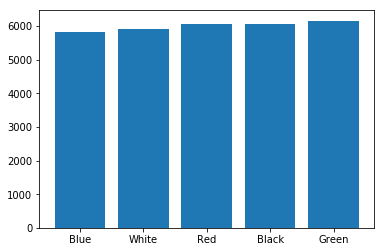

In [17]:
result = %sql SELECT jsonb_array_elements_text(data -> 'colors') AS colors, count(*) FROM cards GROUP BY jsonb_array_elements_text(data -> 'colors') ORDER BY count(*) ASC;
data = np.array(result)
colors, values = data.T
values = list(map(int, values))
colors = list(map(str, colors))

fig = plt.figure()
ax = fig.add_subplot(111)

x_coordinates = np.arange(len(colors))
ax.bar(x_coordinates, values, align='center')

ax.xaxis.set_major_locator(plt.FixedLocator(x_coordinates))
ax.xaxis.set_major_formatter(plt.FixedFormatter(colors))

plt.show()